<a href="https://colab.research.google.com/github/AyaTareekAhmmeed/project/blob/main/eye_disease_better_without_lime_and_with_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -uq "/content/drive/MyDrive/archive (1).zip" -d "/content/drive/My Drive/PATH_TO_OUTPUT"

In [2]:
#importing libraries 
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
# Add an additional column, mapping to the type
df = pd.read_csv('/content/drive/MyDrive/PATH_TO_OUTPUT/train.csv')

#binary to set data into Rd and non RD 
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

#normal diagnosis to all stage/types of disease 
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


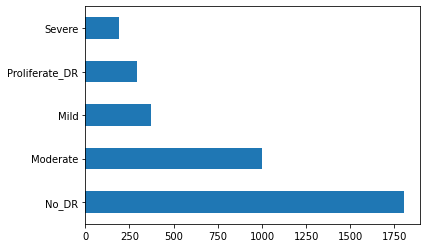

In [4]:
df['type'].value_counts().plot(kind='barh')

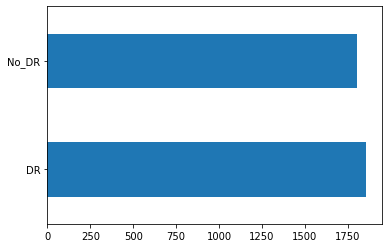

In [5]:
df['binary_type'].value_counts().plot(kind='barh')

In [6]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [7]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [8]:
# Copy images to respective working directory
src_dir = '/content/drive/MyDrive/PATH_TO_OUTPUT/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [9]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [53]:
# creating a CNN with an inception module
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate #for inception 
from keras.utils import plot_model

model = tf.keras.Sequential([
    layers.Conv2D(8, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.Conv2D(8, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])
# summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 224, 224, 8)       32        
                                                                 
 conv2d_101 (Conv2D)         (None, 224, 224, 8)       72        
                                                                 
 conv2d_102 (Conv2D)         (None, 222, 222, 8)       584       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 batch_normalization_97 (Bat  (None, 111, 111, 8)      32        
 chNormalization)                                                
                                                                 
 conv2d_103 (Conv2D)         (None, 111, 111, 16)     

In [54]:
batch_size = 128 #split training data into n batches for higher performance 
epochs = 30 #one forward%backward pass of all training examples

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy']
              )

model.fit(train_batches,
          epochs=epochs,
           verbose=1,
          validation_data=val_batches,
          batch_size=batch_size)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


81/81 [==============================] - 11s 122ms/step - loss: 0.4093 - accuracy: 0.8314 - val_loss: 0.6954 - val_accuracy: 0.5073
Epoch 2/30
81/81 [==============================] - 9s 106ms/step - loss: 0.2455 - accuracy: 0.9133 - val_loss: 0.7014 - val_accuracy: 0.5073
Epoch 3/30
81/81 [==============================] - 9s 106ms/step - loss: 0.2166 - accuracy: 0.9282 - val_loss: 0.6744 - val_accuracy: 0.5145
Epoch 4/30
81/81 [==============================] - 9s 112ms/step - loss: 0.2021 - accuracy: 0.9333 - val_loss: 0.5579 - val_accuracy: 0.6127
Epoch 5/30
81/81 [==============================] - 8s 102ms/step - loss: 0.1821 - accuracy: 0.9438 - val_loss: 0.3864 - val_accuracy: 0.8455
Epoch 6/30
81/81 [==============================] - 8s 96ms/step - loss: 0.1787 - accuracy: 0.9434 - val_loss: 0.2718 - val_accuracy: 0.8927
Epoch 7/30
81/81 [==============================] - 11s 130ms/step - loss: 0.1691 - accuracy: 0.9473 - val_loss: 0.1994 - val_accuracy: 0.9327
Epoch 8/30
81/81

In [56]:
loss, acc = model.evaluate_generator(test_batches)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-56-e0f966fd19f7>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches)


Loss:  0.19000829756259918
Accuracy:  0.9272727370262146


In [57]:
#saving model to reuse its weights
model.save("eye_disease_model.h5")
model.save("eye_disease_model.pkl")
model.save('eye_disease_model.model')


print('saved')

saved


In [58]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("/content/eye_disease_model.pkl")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

1/1 [==============================] - 0s 112ms/step
DR


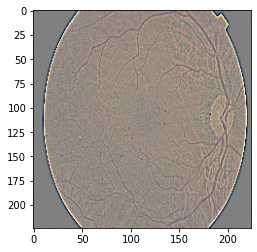

In [60]:
#Mild dir
predict_class('/content/04ac765f91a1.png')

1/1 [==============================] - 0s 180ms/step
DR


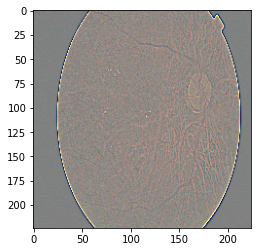

In [61]:
#Moderated dir
predict_class('/content/012a242ac6ff.png')

1/1 [==============================] - 0s 108ms/step
No DR


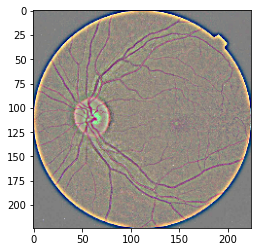

In [62]:
#No dir
predict_class('/content/00cc2b75cddd.png')

In [19]:
!pip install lime
!pip install nets
!pip install preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ee8dd2db3ca2944d97edb95123b35436ebd9d40fd29fa528e92be5d8d2da7146
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 KB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.6/349.6 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.3